# **INSTALLATION BIBLIOTHEQUES**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import display, Image
from ipywidgets import widgets
from concurrent.futures import ThreadPoolExecutor

# **Étape 1 : chargement et prétraitement des données**

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Path to the dataset
#/content/drive/MyDrive/TNI
image_dir = r'/content/drive/MyDrive/TNI/All_img'
csv_path = r'/content/drive/MyDrive/TNI/dataset/val_data.csv'


# Load CSV file
df = pd.read_csv(csv_path)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize image
    return img

# Load images and labels
images = []
labels = []
for index, row in df.iterrows():
    img_path = os.path.join(image_dir, row['Filename'])
    images.append(load_and_preprocess_image(img_path))
    labels.append(row['AQI'])

X = np.array(images)
y = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('AQI Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of AQI Classes in Training Dataset')
plt.show()


KeyboardInterrupt: 

# **Étape 2: Data Augmentation and Class Weights**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# **Étape 3: Definir le model et Fine-Tuning**

In [ ]:
# Define the model (Fine-tuning ResNet50)
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg')
x = base_model.output
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='linear')(x)


model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Étape 3: Entraîner le modèle**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    class_weight=class_weights,
    validation_data=(X_test, y_test)
)

# **Étape 3: Augmentation and Training the Model**

In [ ]:

# Assuming X_train, y_train, X_test, y_test are already defined
# For example, after loading and preprocessing the data as in your previous steps

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define batch size and generator
batch_size = 16
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Load or define your model

# ------------------ Model CNN Simple sans utilisation de resnet50 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# model = tf.keras.models.Sequential([
#     # Define your layers here
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)  # Adjust output layer based on your model's requirements
# ])
# ------------------------- !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Fine-tuning ResNet-50 :::: correcte


# Compile the model if not already compiled
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=30
)


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 716ms/step - loss: 12691.8213 - mae: 86.8060
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 125us/step - loss: 6212.4458 - mae: 62.6279 
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 73s 739ms/step - loss: 8416.1367 - mae: 69.3814
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 115us/step - loss: 6177.9717 - mae: 62.7146  
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 77s 759ms/step - loss: 7690.8569 - mae: 66.3484
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 104us/step - loss: 10616.9180 - mae: 76.2908  
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 73s 740ms/step - loss: 7110.5029 - mae: 64.6012
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 94us/step - loss: 8717.2656 - mae: 75.5155   
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 697ms/step - loss: 7216.5571 - mae: 64.6861
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 73us/step - loss: 1737.9656 - mae: 31.0143  
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 683ms/step - loss: 6780.7446 - mae: 61.6878
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 104us

## Etape **4**: Save the Model *

In [ ]:
# Save the model
from tensorflow.keras.models import save_model
model.save(r'C:\Users\DJAZ\Desktop/air_quality_model.h5')


# **Étape 5: Load the Model**

In [ ]:
import tensorflow as tf
import json
from google.colab import drive


# Mount Google Drive if not already mounted
#drive.mount('/content/drive')

# Load the model with the custom object
try:
    model_path = r'/content/drive/MyDrive/Colab Notebooks/image_polution/air_quality_modelNEW.h5'
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


## Étape 6 TEST

Button(description='Upload Image', style=ButtonStyle())

Button(description='Upload Video', style=ButtonStyle())

Saving BENGR_Good_2023-02-19-08.30-1-39.jpg to BENGR_Good_2023-02-19-08.30-1-39.jpg


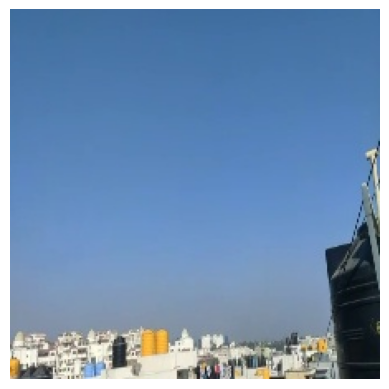

1/1 [==============================] - 0s 355ms/step
Predicted AQI for the uploaded image: 380.77
Air Quality Class: Hazardous


Saving DEL_VUnH_2023-02-16-17.00-2-104.jpg to DEL_VUnH_2023-02-16-17.00-2-104.jpg


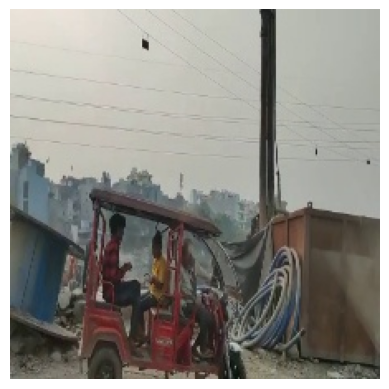

1/1 [==============================] - 0s 46ms/step
Predicted AQI for the uploaded image: 219.77
Air Quality Class: Very Unhealthy


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from google.colab import files  # Remove this import as it's not needed locally
import ipywidgets as widgets
from IPython.display import display
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
from ipywidgets import FileUpload

# Helper function to classify AQI
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'
def predict_image(img):
    img = cv2.resize(img, (224, 224))  # Assuming your model expects this input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    return prediction[0][0]  # Extract the AQI prediction
# User Interface for Uploading Files
def upload_image():
    uploaded = files.upload()
    for name, data in uploaded.items():
        img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        prediction = predict_image(img)
        aqi_class = classify_aqi(prediction)
        print(f'Predicted AQI for the uploaded image: {prediction:.2f}')
        print(f'Air Quality Class: {aqi_class}')


image_button = widgets.Button(description="Upload Image")
image_button.on_click(lambda x: upload_image())
display(image_button)



